In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import pickle
import os


# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

from ph1 import *
from load_cifar10 import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

reset_seed(0)

2.4.1
cuda


In [10]:
to_float= torch.float
to_long = torch.long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
data_dir='./datasets'
loader_train, loader_val, loader_test = load_CIFAR10(data_dir, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


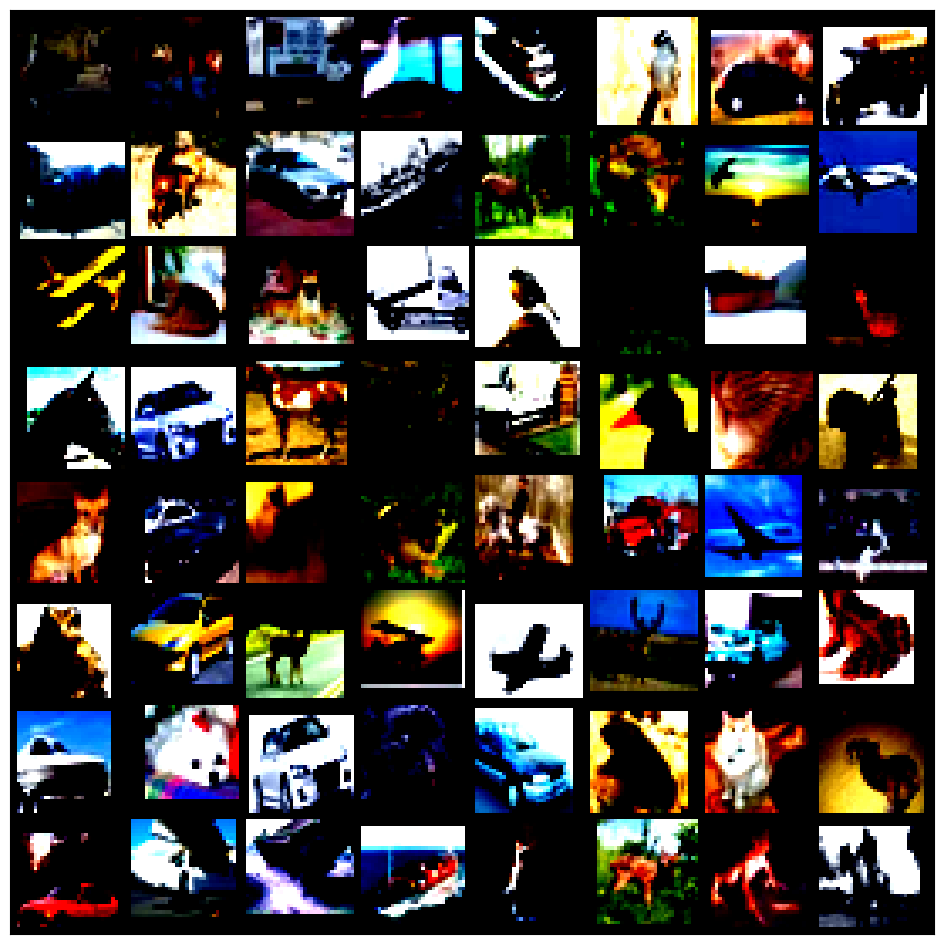

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
show_batch(loader_train)

In [13]:
networks = {
    'resnet18_light': {
        'block': ResidualBlock,
        'stage_args': [
            (32, 64, 2, False),
            (64, 128, 2, True),
            (128, 256, 2, True),
            (256, 512, 2, True)
        ],
        'dropout': True,  # Enable dropout
        'p': 0.4  # Dropout probability
    }
}

def get_resnet(name):
  return ResNet(**networks[name])

resnet18_light 

Starting epoch 1/100...
Validation accuracy: 1024 / 5000 (20.48%)
Starting epoch 2/100...
Validation accuracy: 1475 / 5000 (29.50%)
Starting epoch 3/100...
Validation accuracy: 1796 / 5000 (35.92%)
Starting epoch 4/100...
Validation accuracy: 2329 / 5000 (46.58%)
Starting epoch 5/100...
Validation accuracy: 2341 / 5000 (46.82%)
Starting epoch 6/100...
Validation accuracy: 2200 / 5000 (44.00%)
Starting epoch 7/100...
Validation accuracy: 2491 / 5000 (49.82%)
Starting epoch 8/100...
Validation accuracy: 2629 / 5000 (52.58%)
Starting epoch 9/100...
Validation accuracy: 3275 / 5000 (65.50%)
Starting epoch 10/100...
Validation accuracy: 3236 / 5000 (64.72%)
Starting epoch 11/100...
Validation accuracy: 3553 / 5000 (71.06%)
Starting epoch 12/100...
Validation accuracy: 3492 / 5000 (69.84%)
Starting epoch 13/100...
Validation accuracy: 3464 / 5000 (69.28%)
Starting epoch 14/100...
Validation accuracy: 3798 / 5000 (75.96%)
Starting epoch 15/100...
Validation accuracy: 3850 / 5

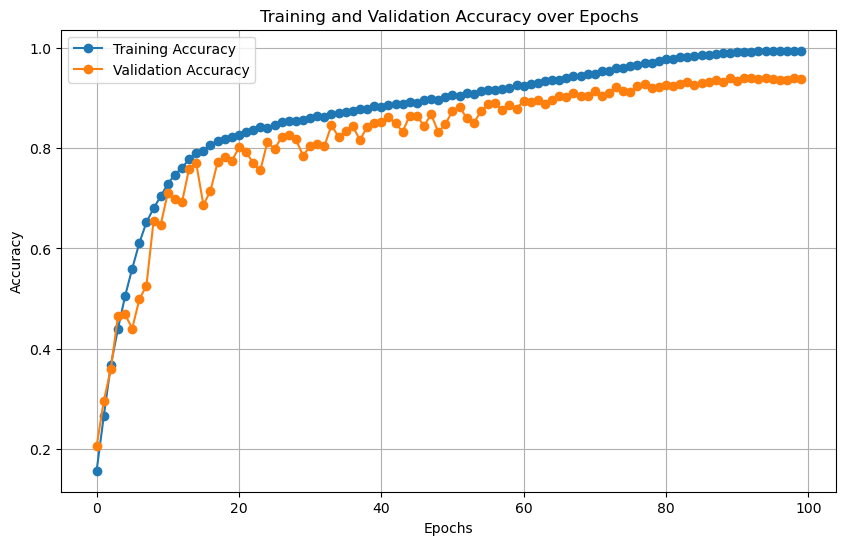

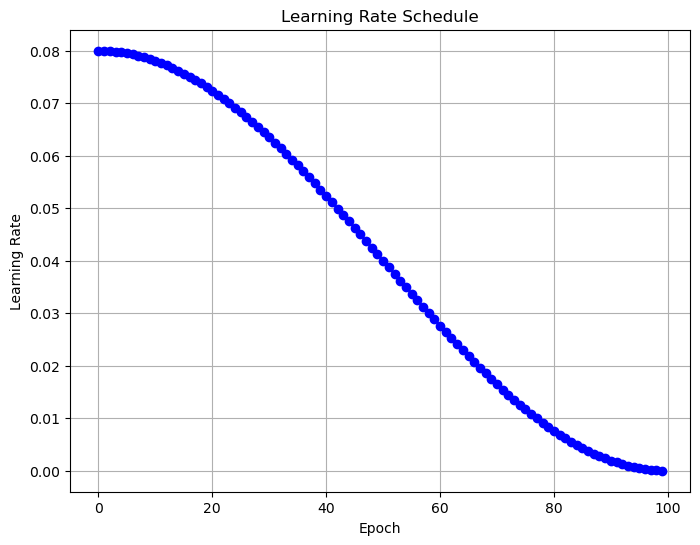

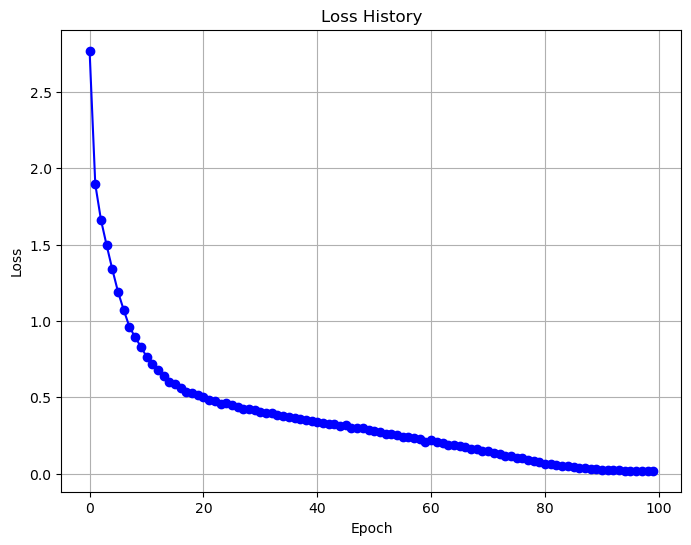

In [14]:
# TODO increase dropout
# TODO add T_mult
# TODO increase batch size
# TODO increase weight decay


name = 'resnet18_light'
version = 10

model_path = f'./models/{name}_{version}.pth'
history_path = f'./history/{name}_{version}.pth'

if os.path.exists(model_path):
  model = get_resnet(name).to(device) 
  state_dict = torch.load(model_path, weights_only=True)
  model.load_state_dict(state_dict)
  check_accuracy(loader_test, model, device='cuda')

  with open(history_path, 'rb') as f:
    train_acc_history, val_acc_history, lr_history, train_loss_history = pickle.load(f)
  
  plot_val_train_acc(train_acc_history, val_acc_history)
  plot_learning_rate(lr_history)
  plot_loss(train_loss_history)
else:
  print(name, '\n')
  model = get_resnet(name).to(device)
  model.apply(initialize_weights)
  optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=.95, weight_decay=1e-3)
  scheduler = CosineAnnealingLR(optimizer, T_max=100)
  # scheduler = StepLR(optimizer, step_size=12, gamma=0.5)

  train_acc_history, val_acc_history, lr_history, train_loss_history = train_model(model, optimizer, loader_train,
                                                  loader_val,device='cuda',epochs=100,
                                                  schedule=[6, 15], scheduler=scheduler,
                                                  verbose=False, model_path=model_path)
  torch.save(model.state_dict(), model_path)
  with open(history_path, 'wb') as f:
        pickle.dump((train_acc_history, val_acc_history, lr_history, train_loss_history), f)


  check_accuracy(loader_test, model, device='cuda')
  plot_val_train_acc(train_acc_history, val_acc_history)
  plot_learning_rate(lr_history)
  plot_loss(train_loss_history)